[![Roboflow Notebooks](https://media.roboflow.com/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# How to Train YOLO11 Object Detection on a Custom Dataset

---

[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/ultralytics/ultralytics)

YOLO11 builds on the advancements introduced in YOLOv9 and YOLOv10 earlier this year, incorporating improved architectural designs, enhanced feature extraction techniques, and optimized training methods.

YOLO11m achieves a higher mean mAP score on the COCO dataset while using 22% fewer parameters than YOLOv8m, making it computationally lighter without sacrificing performance.

YOLOv11 is available in 5 different sizes, ranging from `2.6M` to `56.9M` parameters, and capable of achieving from `39.5` to `54.7` mAP on the COCO dataset.

## Setup

### Configure API keys

To fine-tune YOLO11, you need to provide your Roboflow API key. Follow these steps:

- Go to your [`Roboflow Settings`](https://app.roboflow.com/settings/api) page. Click `Copy`. This will place your private key in the clipboard.
- In Colab, go to the left pane and click on `Secrets` (🔑). Store Roboflow API Key under the name `ROBOFLOW_API_KEY`.

### Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [ ]:
!nvidia-smi

Thu Oct 16 19:09:35 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   35C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [ ]:
import os
HOME = os.getcwd()
print(HOME)

/content


## Install YOLO11 via Ultralytics

In [ ]:
%pip install "ultralytics<=8.3.40" supervision roboflow
# prevent ultralytics from tracking your activity
!yolo settings sync=False
import ultralytics
ultralytics.checks()

Ultralytics 8.3.40 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 39.6/112.6 GB disk)


## Inference with model pre-trained on COCO dataset

### CLI

**NOTE:** CLI requires no customization or Python code. You can simply run all tasks from the terminal with the yolo command.

In [ ]:
!yolo task=detect mode=predict model=yolo11n.pt conf=0.25 source='https://media.roboflow.com/notebooks/examples/dog.jpeg' save=True

100% 5.35M/5.35M [00:00<00:00, 108MB/s]
Ultralytics 8.3.40 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 238 layers, 2,616,248 parameters, 0 gradients, 6.5 GFLOPs

100% 104k/104k [00:00<00:00, 124MB/s]
image 1/1 /content/dog.jpeg: 640x384 2 persons, 1 car, 1 dog, 1 handbag, 46.3ms
Speed: 4.9ms preprocess, 46.3ms inference, 238.5ms postprocess per image at shape (1, 3, 640, 384)
Results saved to runs/detect/predict
💡 Learn more at https://docs.ultralytics.com/modes/predict


**NOTE:** Result annotated image got saved in `{HOME}/runs/detect/predict/`. Let's display it.

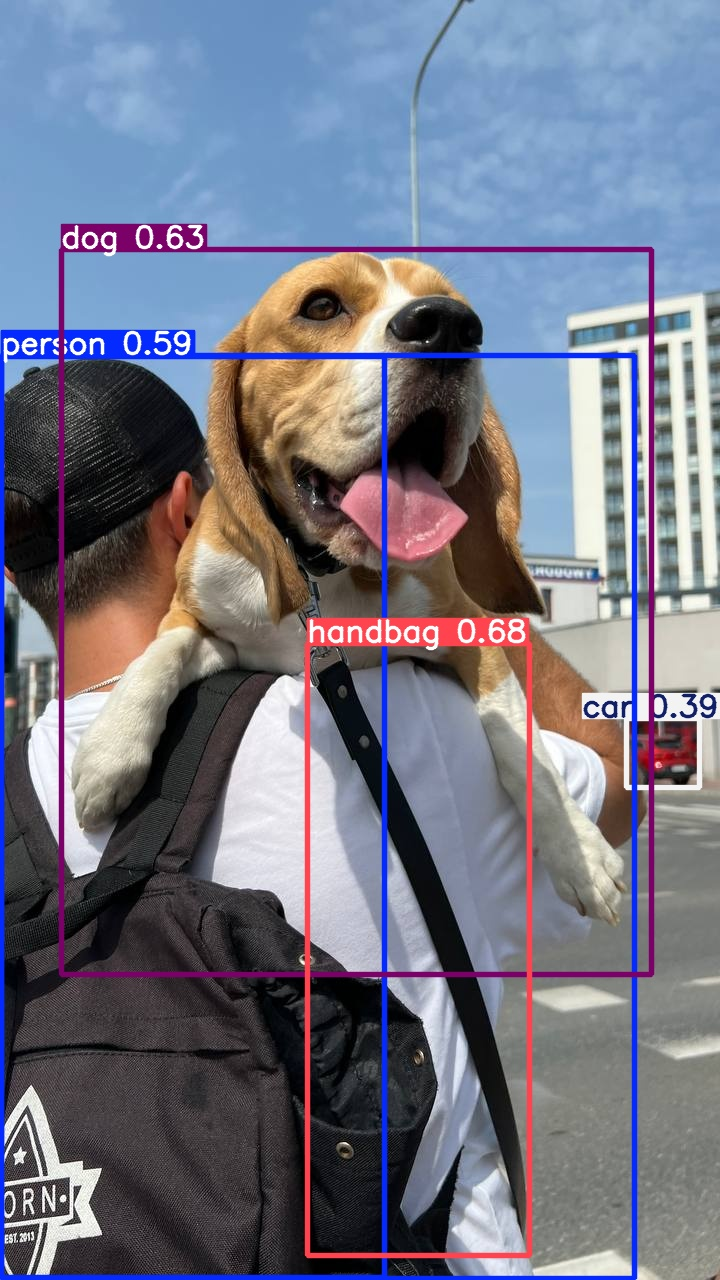

In [ ]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/predict/dog.jpg', width=600)

### SDK

**NOTE:** YOLO's Python interface allows for seamless integration into your Python projects, making it easy to load, run, and process the model's output.

In [ ]:
from ultralytics import YOLO
from PIL import Image
import requests

model = YOLO('yolo11n.pt')
image = Image.open(requests.get('https://media.roboflow.com/notebooks/examples/dog.jpeg', stream=True).raw)
result = model.predict(image, conf=0.25)[0]


0: 640x384 2 persons, 1 car, 1 dog, 1 handbag, 46.6ms
Speed: 2.7ms preprocess, 46.6ms inference, 73.3ms postprocess per image at shape (1, 3, 640, 384)


**NOTE:** The obtained `result` object stores information about the location, classes, and confidence levels of the detected objects.

In [ ]:
result.boxes.xyxy

tensor([[3.0705e+02, 6.4341e+02, 5.2919e+02, 1.2558e+03],
        [6.1400e+01, 2.4994e+02, 6.5165e+02, 9.7412e+02],
        [1.7803e+00, 3.5551e+02, 6.3404e+02, 1.2788e+03],
        [1.1933e+00, 3.5620e+02, 3.8455e+02, 1.2776e+03],
        [6.2615e+02, 7.1818e+02, 6.9975e+02, 7.8754e+02]], device='cuda:0')

In [ ]:
result.boxes.conf

tensor([0.6832, 0.6284, 0.5941, 0.3923, 0.3875], device='cuda:0')

In [ ]:
result.boxes.cls

tensor([26., 16.,  0.,  0.,  2.], device='cuda:0')

**NOTE:** YOLO11 can be easily integrated with `supervision` using the familiar `from_ultralytics` connector.

In [ ]:
import supervision as sv

detections = sv.Detections.from_ultralytics(result)

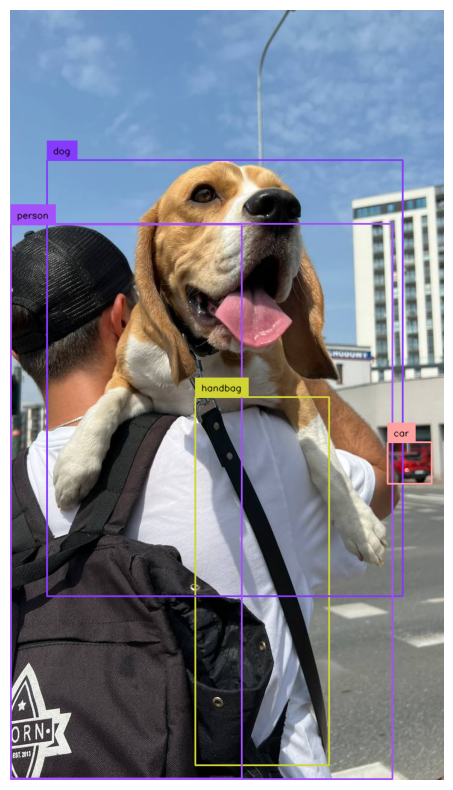

In [ ]:
box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator(text_color=sv.Color.BLACK)

annotated_image = image.copy()
annotated_image = box_annotator.annotate(annotated_image, detections=detections)
annotated_image = label_annotator.annotate(annotated_image, detections=detections)

sv.plot_image(annotated_image, size=(10, 10))

## Fine-tune YOLO11 on custom dataset

**NOTE:** When training YOLOv11, make sure your data is located in `datasets`. If you'd like to change the default location of the data you want to use for fine-tuning, you can do so through Ultralytics' `settings.json`. In this tutorial, we will use one of the [datasets](https://universe.roboflow.com/liangdianzhong/-qvdww) available on [Roboflow Universe](https://universe.roboflow.com/). When downloading, make sure to select the `yolov11` export format.

In [ ]:
!mkdir {HOME}/datasets
%cd {HOME}/datasets

from google.colab import userdata

from roboflow import Roboflow
rf = Roboflow(api_key="")
project = rf.workspace("robiul-awoul-robin-bfbb5").project("phyeq24-utchc")
version = project.version(5)
dataset = version.download("yolov11")

/content/datasets
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to PhyEq24-5 in yolov11:: 100%|██████████| 7192/7192 [00:00<00:00, 8427.03it/s]


## Custom Training

In [ ]:
%cd {HOME}

!yolo task=detect mode=train model=yolo11s.pt data={dataset.location}/data.yaml epochs=100 imgsz=640 plots=True

/content
100% 18.4M/18.4M [00:00<00:00, 204MB/s]
New https://pypi.org/project/ultralytics/8.3.216 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.40 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolo11s.pt, data=/content/datasets/PhyEq24-5/data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=

**NOTE:** The results of the completed training are saved in `{HOME}/runs/detect/train/`. Let's examine them.

In [ ]:
!ls {HOME}/runs/detect/train/

args.yaml					    train_batch14220.jpg
confusion_matrix_normalized.png			    train_batch14221.jpg
confusion_matrix.png				    train_batch14222.jpg
events.out.tfevents.1760641917.0bbf41df4e91.1778.0  train_batch1.jpg
F1_curve.png					    train_batch2.jpg
labels_correlogram.jpg				    val_batch0_labels.jpg
labels.jpg					    val_batch0_pred.jpg
P_curve.png					    val_batch1_labels.jpg
PR_curve.png					    val_batch1_pred.jpg
R_curve.png					    val_batch2_labels.jpg
results.csv					    val_batch2_pred.jpg
results.png					    weights
train_batch0.jpg


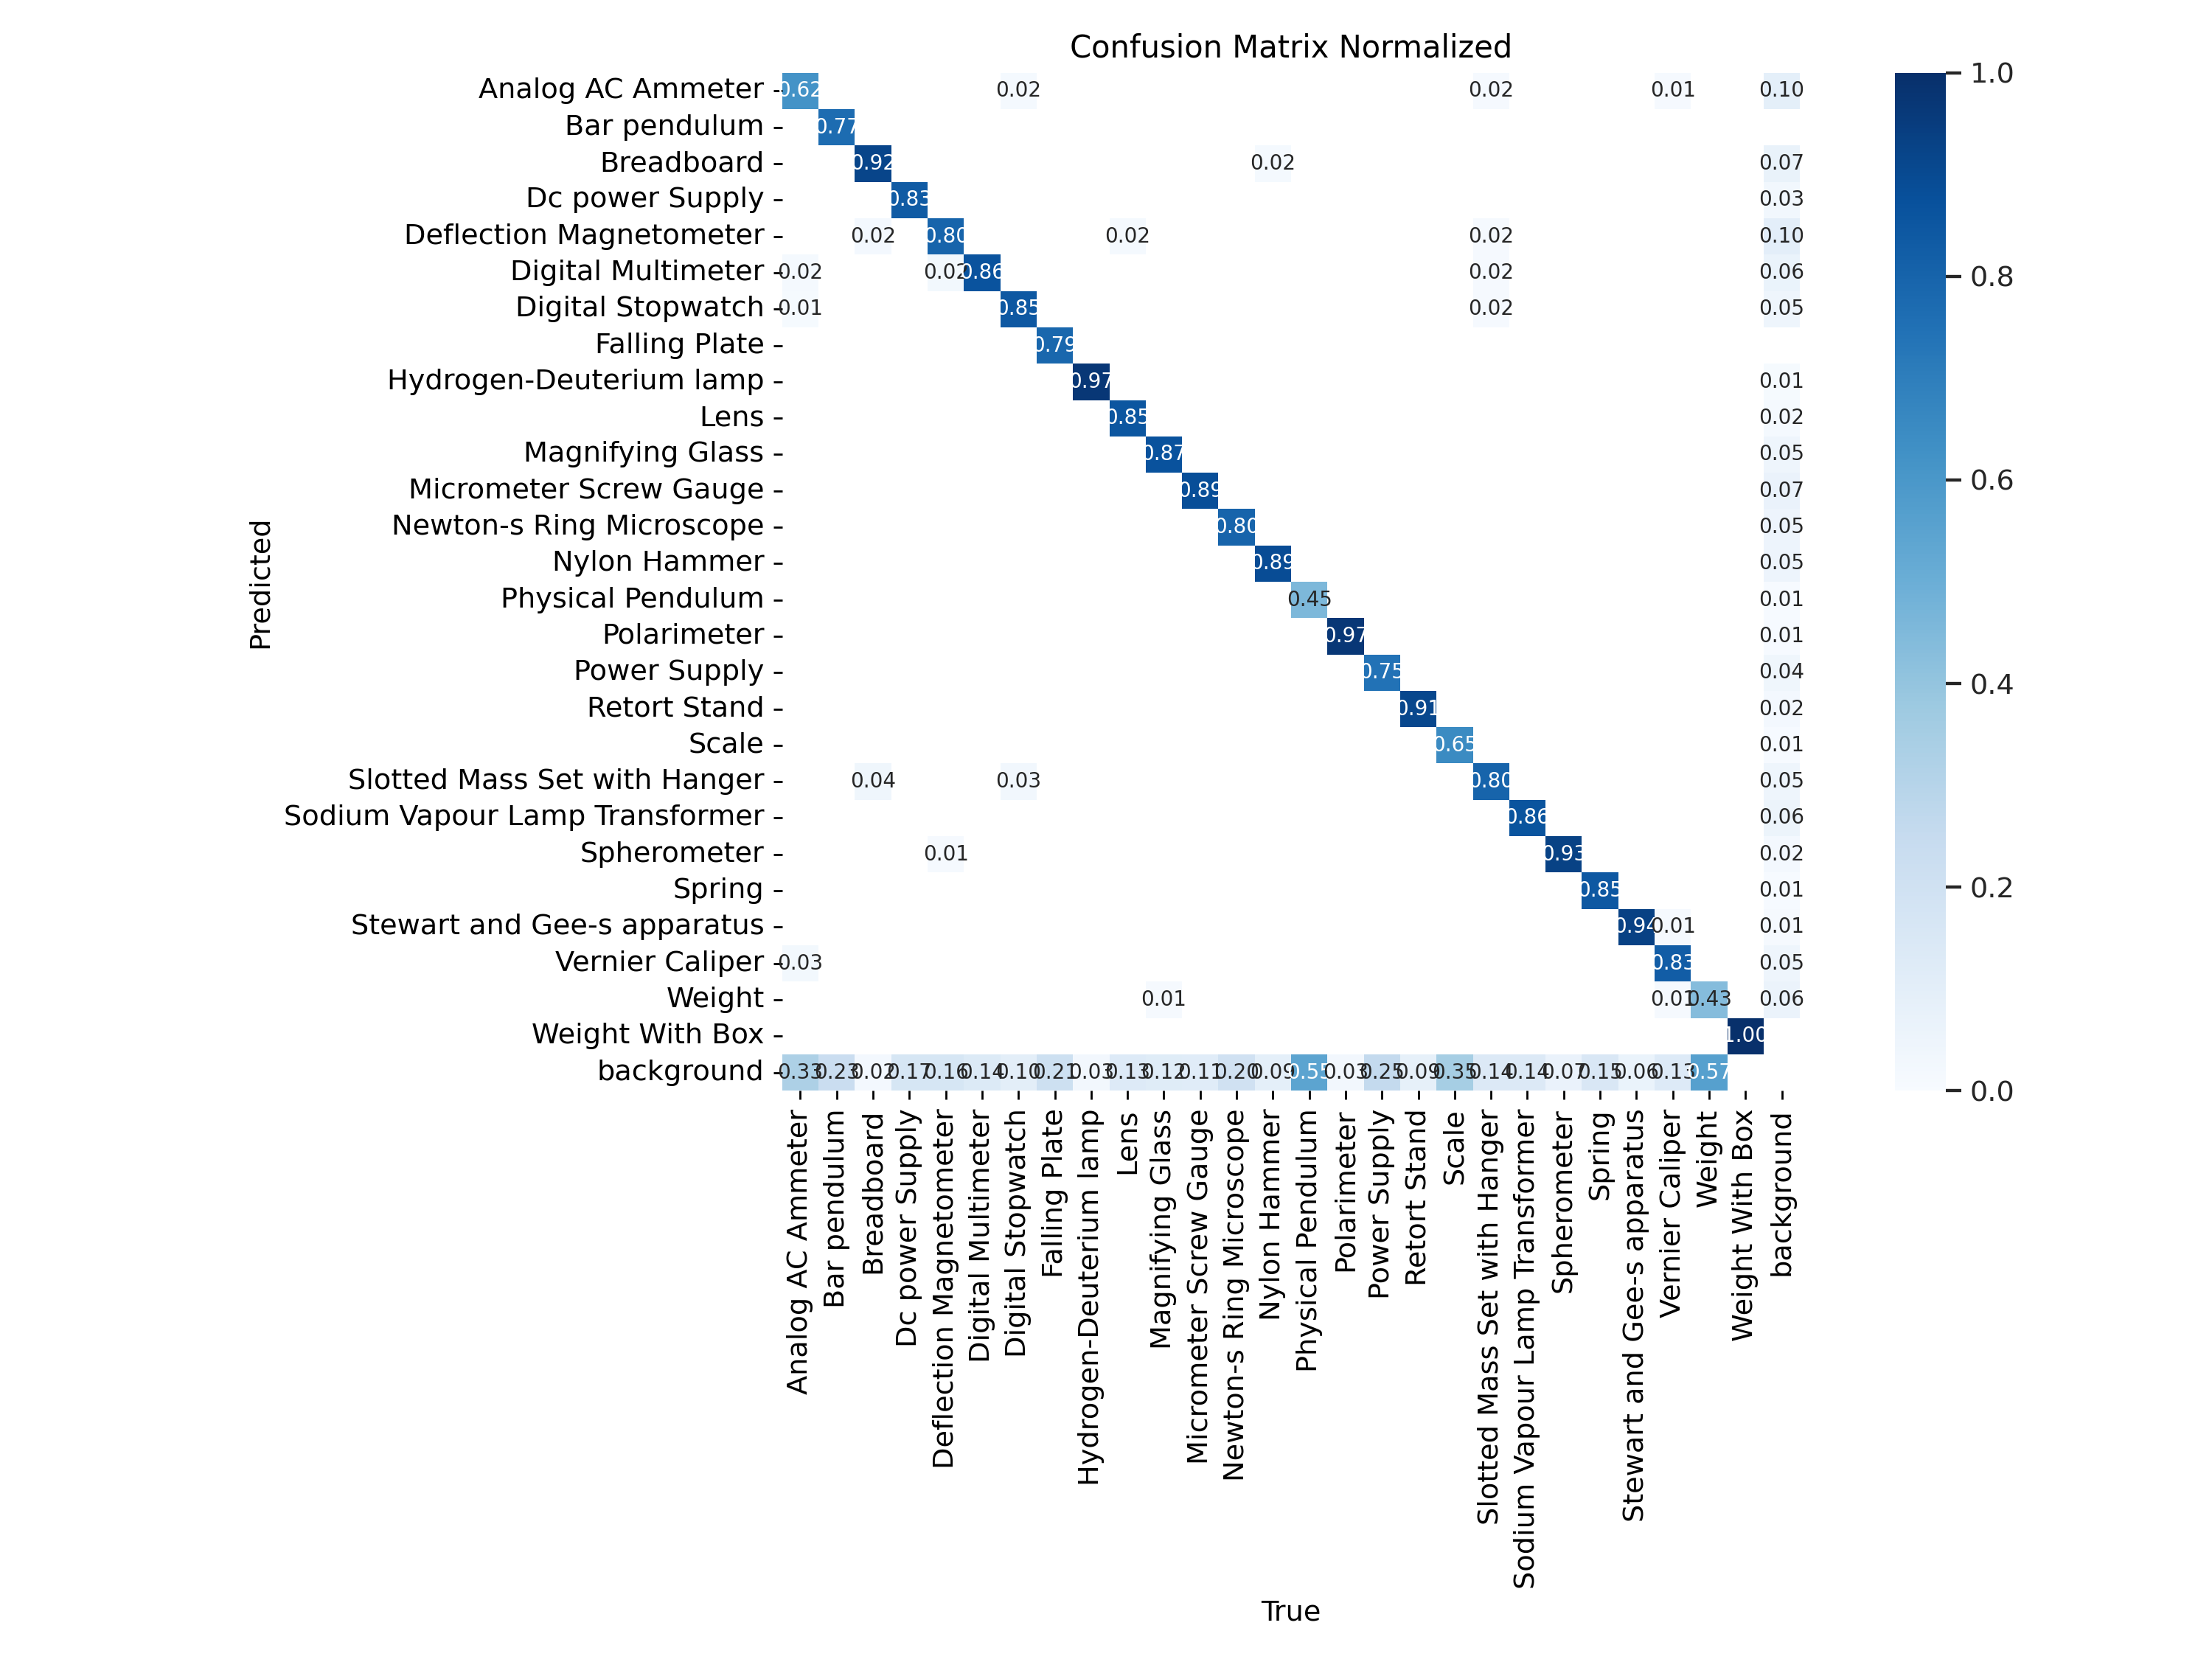

In [ ]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train/confusion_matrix_normalized.png', width=600)

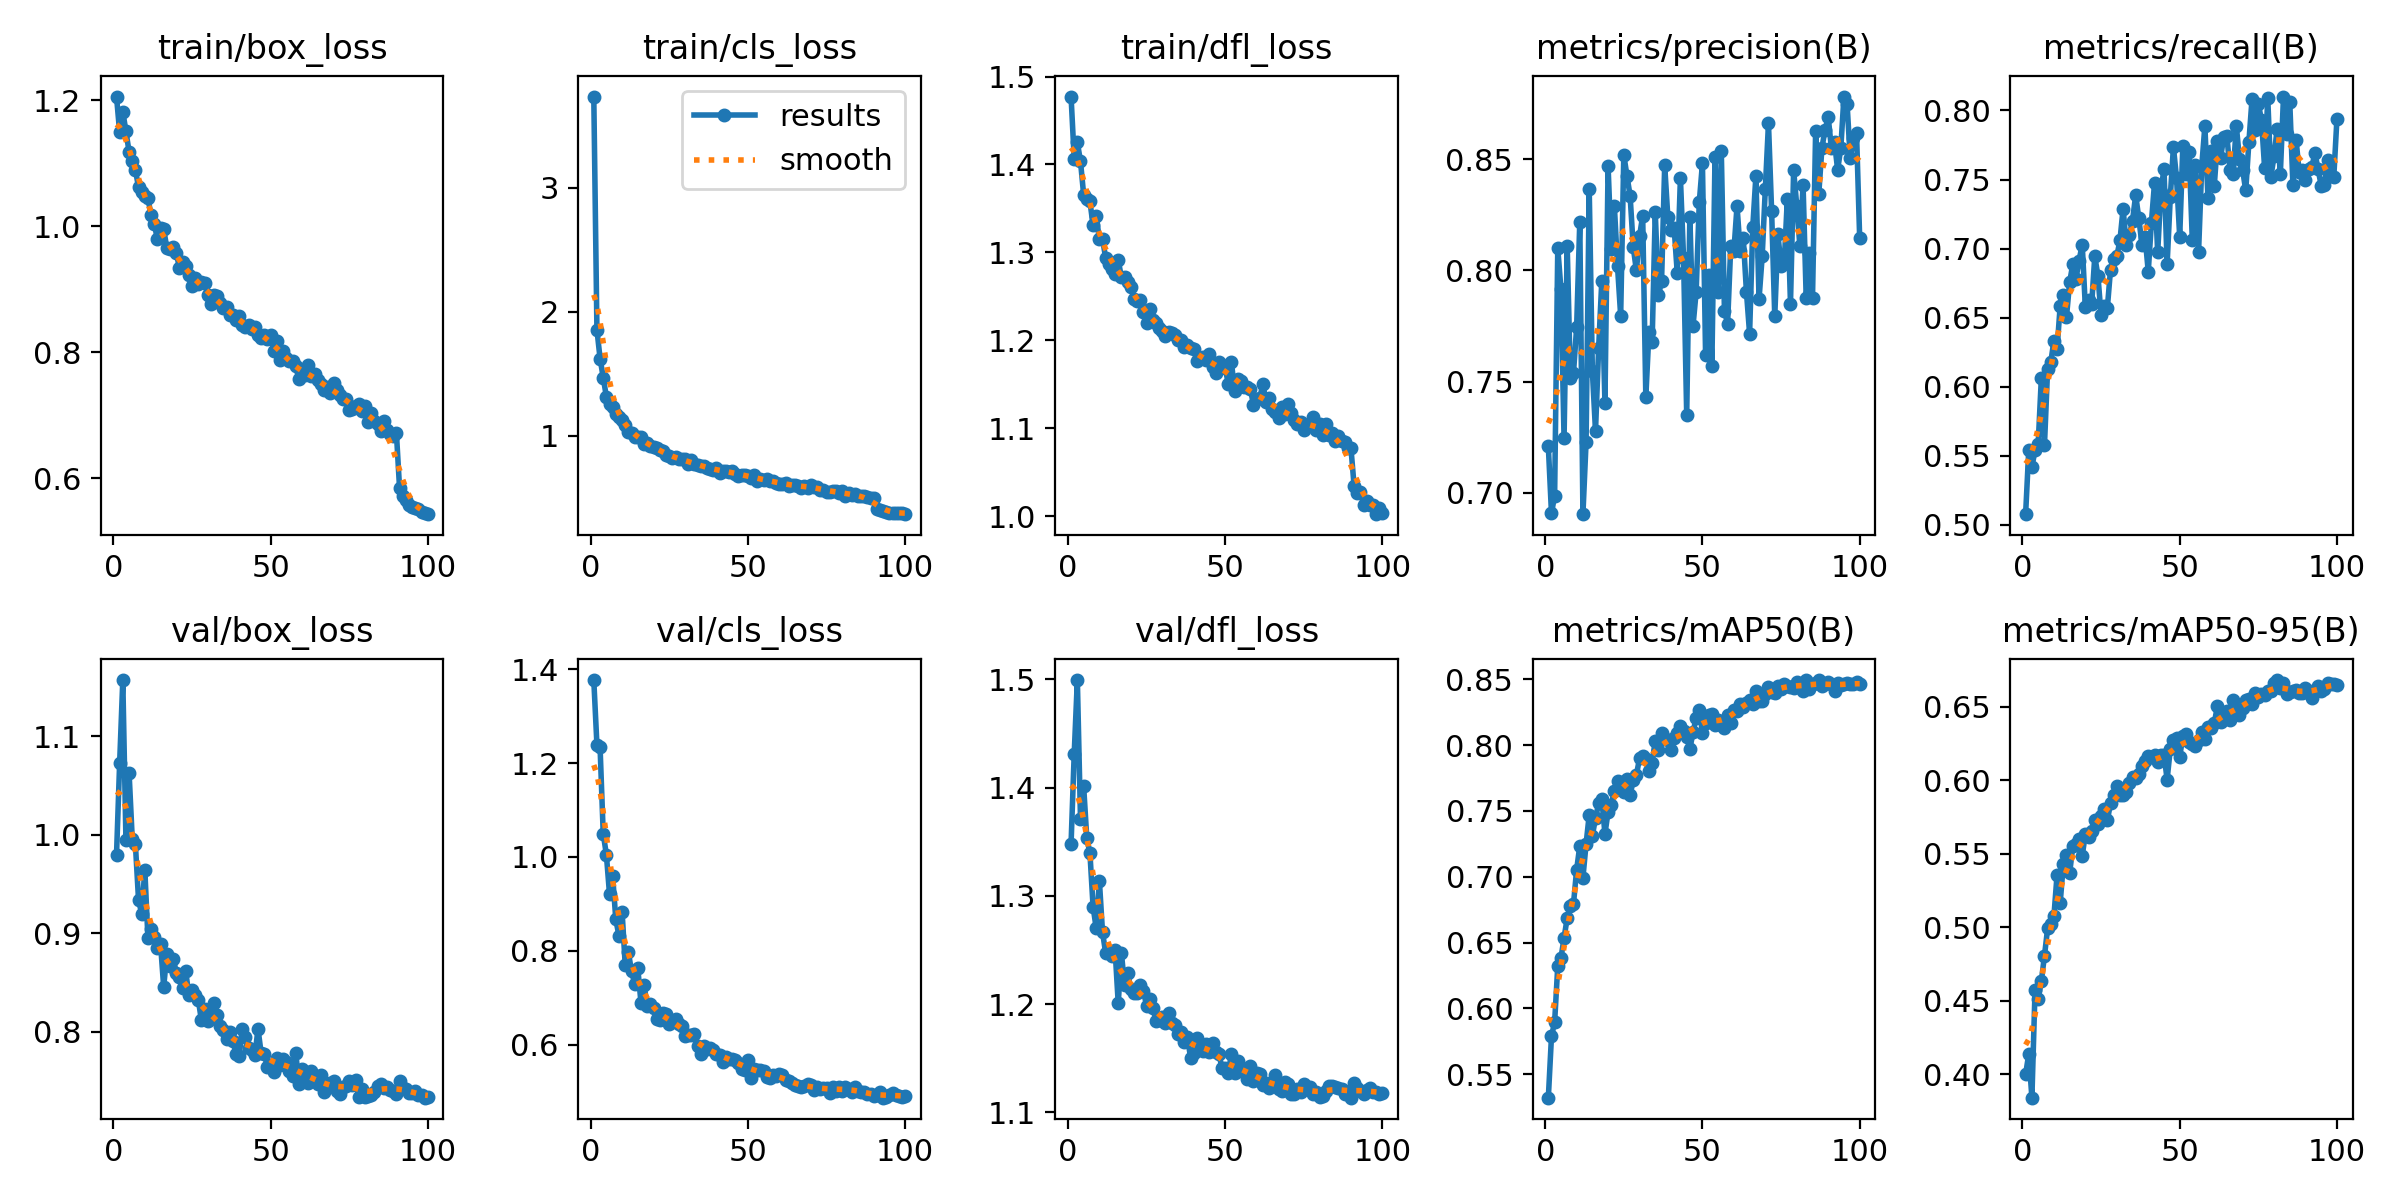

In [ ]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train/results.png', width=600)

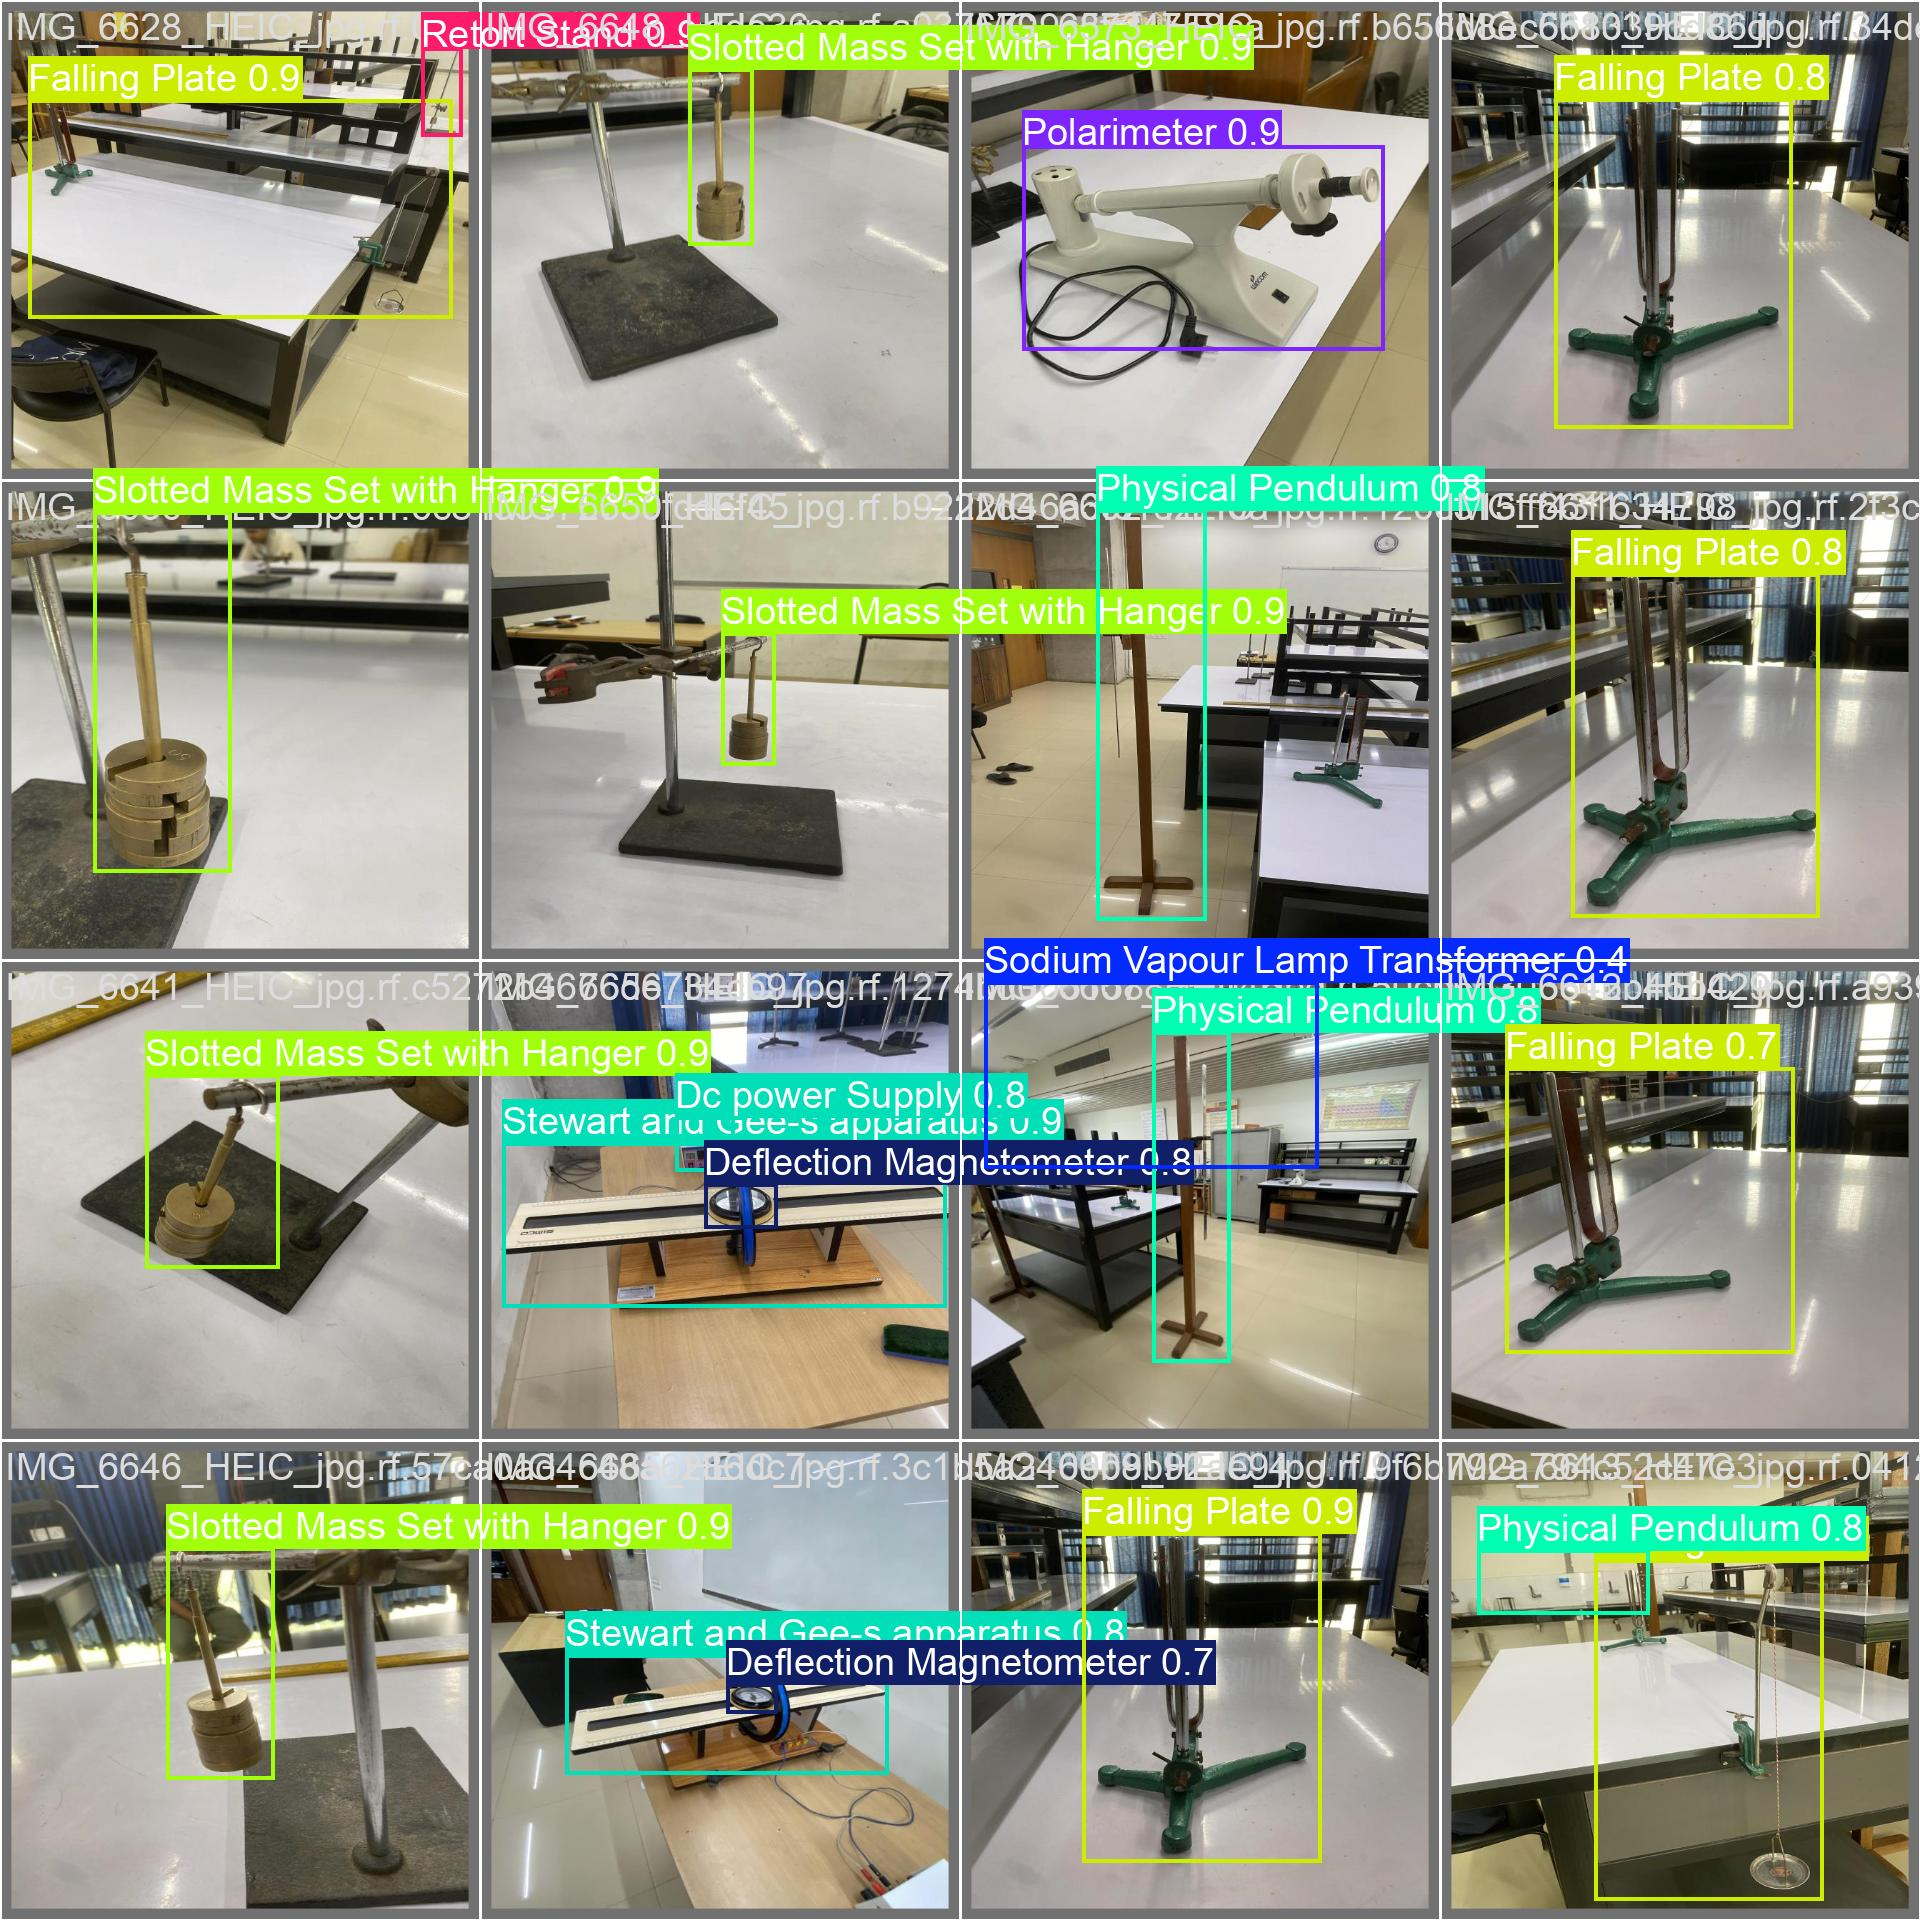

In [ ]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train/val_batch0_pred.jpg', width=600)

## Validate fine-tuned model

In [ ]:
!yolo task=detect mode=val model={HOME}/runs/detect/train/weights/best.pt data={dataset.location}/data.yaml

Ultralytics 8.3.40 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s summary (fused): 238 layers, 9,423,249 parameters, 0 gradients, 21.4 GFLOPs
val: Scanning /content/datasets/PhyEq24-5/valid/labels.cache... 717 images, 0 backgrounds, 0 corrupt: 100% 717/717 [00:00<?, ?it/s]
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 657, len(boxes) = 1523. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 45/45 [00:10<00:00,  4.37it/s]
                   all        717       1523      0.811      0.786      0.845      0.667
     Analog AC Ammeter         75        115      0.732      0.617      0.689      0.543
          Bar pendulum         13         13      0.939      0.769      0.784      0.585
            Breadboard         49   

## Inference with custom model

In [ ]:
!yolo task=detect mode=predict model={HOME}/runs/detect/train/weights/best.pt conf=0.25 source={dataset.location}/test/images save=True

Ultralytics 8.3.40 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s summary (fused): 238 layers, 9,423,249 parameters, 0 gradients, 21.4 GFLOPs

image 1/359 /content/datasets/PhyEq24-5/test/images/20250921_145342_jpg.rf.88aeb8a76fc8aef9c969195c292ab248.jpg: 640x640 3 Analog AC Ammeters, 1 Newton-s Ring Microscope, 1 Power Supply, 15.3ms
image 2/359 /content/datasets/PhyEq24-5/test/images/20250921_145350_jpg.rf.383521846a875108edef70a6710f5cb1.jpg: 640x640 1 Newton-s Ring Microscope, 15.3ms
image 3/359 /content/datasets/PhyEq24-5/test/images/20250921_145404_jpg.rf.cd01ec189c2843794d7eae9b85395cdc.jpg: 640x640 1 Newton-s Ring Microscope, 15.4ms
image 4/359 /content/datasets/PhyEq24-5/test/images/20250921_145419_jpg.rf.31109dfc3a53b2cffe13f8101f20c4ed.jpg: 640x640 1 Newton-s Ring Microscope, 15.3ms
image 5/359 /content/datasets/PhyEq24-5/test/images/20250921_145516_jpg.rf.da74a2bdc67745f7f9f6c6cfeb8a87f0.jpg: 640x640 1 Newton-s Ring Microscope, 15.3ms
image 6/359 /co

**NOTE:** Let's take a look at few results.

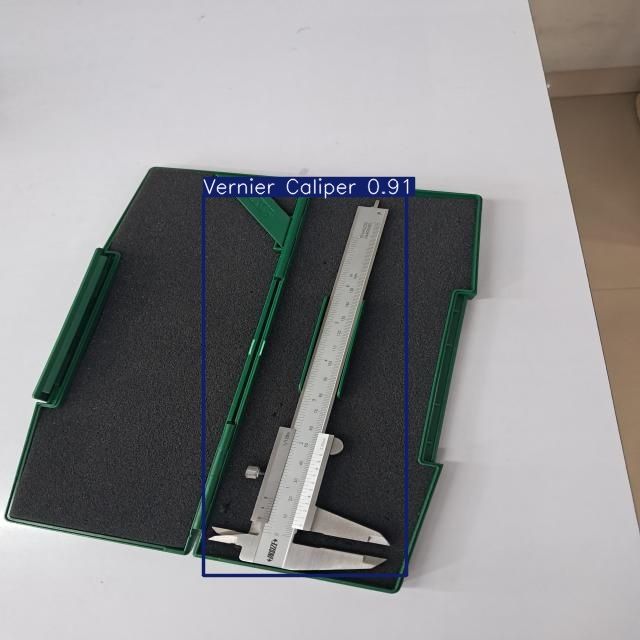

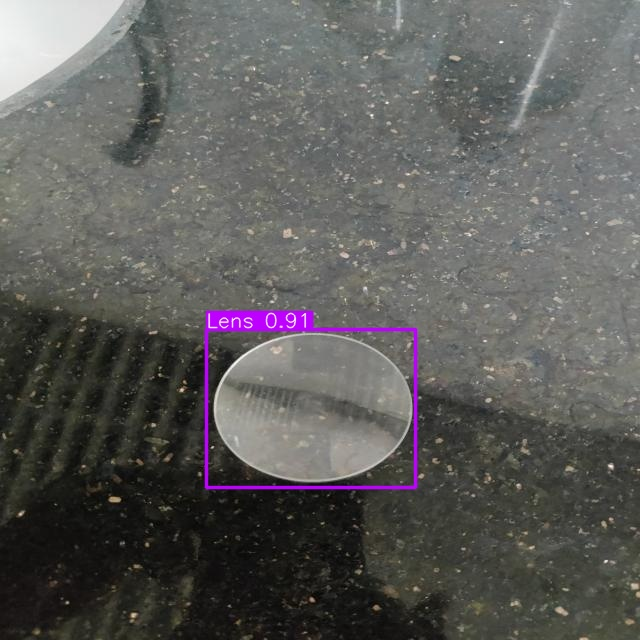

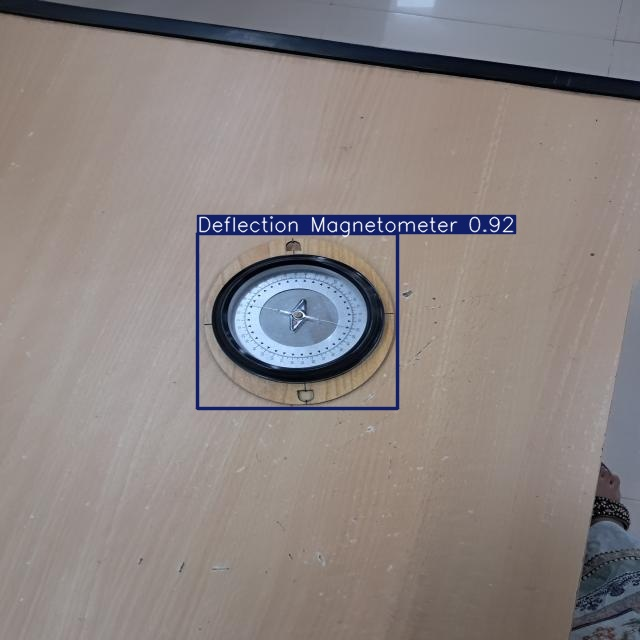

In [ ]:
import glob
import os
from IPython.display import Image as IPyImage, display

latest_folder = max(glob.glob(f'{HOME}/runs/detect/predict*/'), key=os.path.getmtime)
for img in glob.glob(f'{latest_folder}/*.jpg')[:3]:
    display(IPyImage(filename=img, width=600))
    print("\n")

In [ ]:
from google.colab import files
import shutil

# Replace 'your_folder' with the folder you want to download
folder_name = "/content/runs/detect"
zip_name = f"{folder_name}.zip"

# Zip the folder
shutil.make_archive(folder_name, 'zip', folder_name)

# Download the zipped folder
files.download(zip_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>